# Generating SSN with beamconv

In [2]:
import numpy as np
import healpy as hp
from beamconv import ScanStrategy, Beam
import qpoint as qp
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore', category=UserWarning)

## Scanning in Az-El coordinates
The ground does not follow the sky's rotation so needs to be treated differently in beamconv. We start by defining our horizon: a 290K source that occupies a little more than half the sky with sinusoidal elevation.

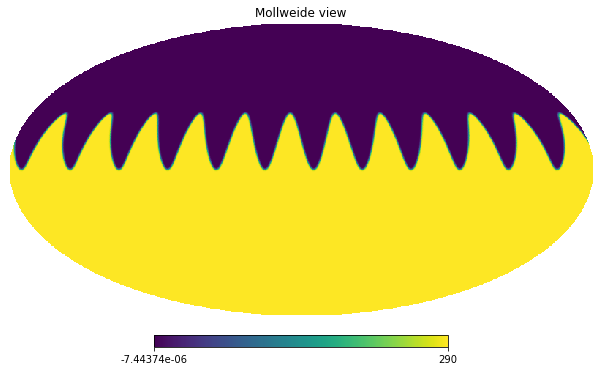

In [3]:
nside = 512
lmax = 700
pixels = np.arange(hp.nside2npix(nside))#all pixels of the healpix map
theta, phi = hp.pix2ang(nside, pixels)#all pixel coordinates 

ground = np.zeros(hp.nside2npix(nside))
ground[theta>(np.pi/2-.25*(np.sin(12*phi)+1))]=290.#horizon condition
ground = hp.smoothing(ground, fwhm=np.pi/180)
sine_alm = hp.map2alm([ground, np.zeros(hp.nside2npix(nside)), np.zeros(hp.nside2npix(nside))], 
                                lmax = lmax)
hp.mollview(ground)

If we look at the auto spectra, there's quite a lot of ringing due to the 'evenness' of the division

Text(0, 0.5, '$D_\\ell^{TT}$ $(K^2)$')

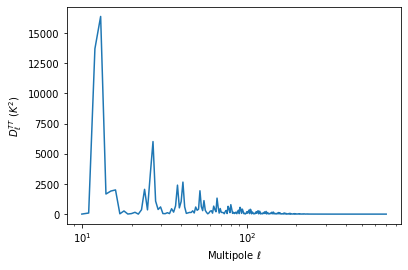

In [4]:
ell = np.arange(lmax+1)
plt.semilogx(ell[10:], ell[10:]*(ell+1)[10:]*hp.anafast(ground, lmax=lmax)[10:]/2/np.pi)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$D_\ell^{TT}$ $(K^2)$')

We also create a beam: it is the sum of two Gaussians, one narrow which is the main beam and one much weaker playing the role of the sidelobes.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


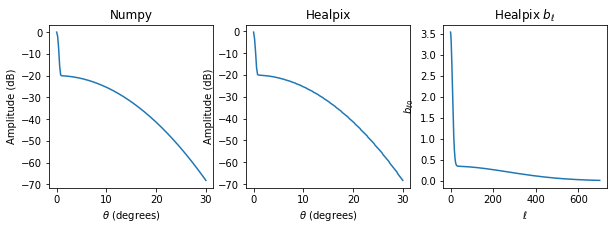

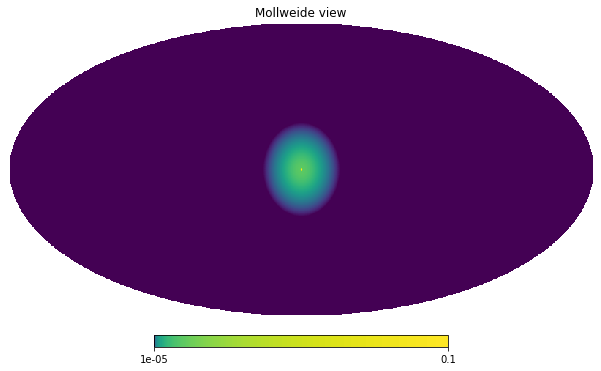

In [5]:
fwhm = np.radians(.5)#main beam, 30 arcmin
side_fwhm = np.radians(15)#sidelobe, 15 degree fwhm!
#1d example
tht = np.linspace(0, np.pi/6, 151)
beam_1d =  0.99*np.exp(-tht**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-tht**2/(2*(side_fwhm/2.355)**2))

#Now the full sky-beam
beam = 0.99*np.exp(-theta**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-theta**2/(2*(side_fwhm/2.355)**2))

#from map to blm
blm = hp.map2alm([beam, beam, np.zeros(hp.nside2npix(nside))], lmax=lmax, mmax=lmax)


fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(tht/np.pi*180., 10*np.log10(beam_1d))
ax[0].set_xlabel(r'$\theta$ (degrees)')
ax[0].set_ylabel('Amplitude (dB)')
ax[0].set_title('Numpy')
ax[1].plot(tht/np.pi*180, 10*np.log10(beam[hp.ang2pix(nside, tht, np.zeros(151))]))
ax[1].set_xlabel(r'$\theta$ (degrees)')
ax[1].set_ylabel('Amplitude (dB)')
ax[1].set_title("Healpix")
ax[2].plot(np.absolute(blm[0, hp.Alm.getidx(701, np.arange(701),0)]*np.sqrt(4*np.pi/ (2*ell + 1)))/blm[0,0])
ax[2].set_xlabel(r'$\ell$')
ax[2].set_ylabel('$b_{\ell0}$')
ax[2].set_title(r"Healpix $b_\ell$")

hp.mollview(beam, rot=[0,90,0], min=1e-5, max=0.1, norm='log', fig=2)

These map based beams have issues with normalization and pixellization, but nothing unsolvable. However, to simplify our work more, we'll use ```beamconv``` and ```healpy```'s functions to create a gaussian+sidelobe directly in $\ell$ space. 

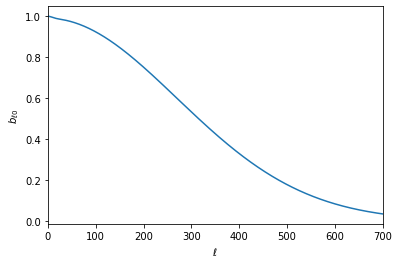

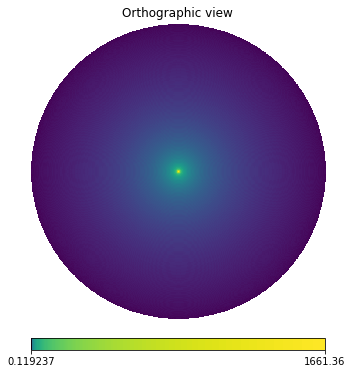

In [6]:
from beamconv import tools
blm_main = tools.gauss_blm(fwhm=30, lmax=700, pol=False)
blm_main *= 0.99
blm_main = tools.get_copol_blm(blm_main, c2_fwhm=30)
blm_side = tools.gauss_blm(fwhm=15*60, lmax=700, pol=False)#
blm_side *= 0.01
blm_side = tools.get_copol_blm(blm_side, c2_fwhm=15*60)
blm = list(np.array(blm_side)+np.array(blm_main))
np.save('./ancillary/gaussian_with_sidelobe', blm, allow_pickle=True)
plt.plot(np.real(blm[0][:lmax+1]))
plt.xlim(0,700)
plt.xlabel(r'$\ell$')
plt.ylabel('$b_{\ell0}$')
hp.orthview(hp.alm2map(blm, nside=nside)[0], rot=[0,90,0], half_sky=True, norm="log")

Various simple beams are possible, depending on sidelobe amplitude and fwhm

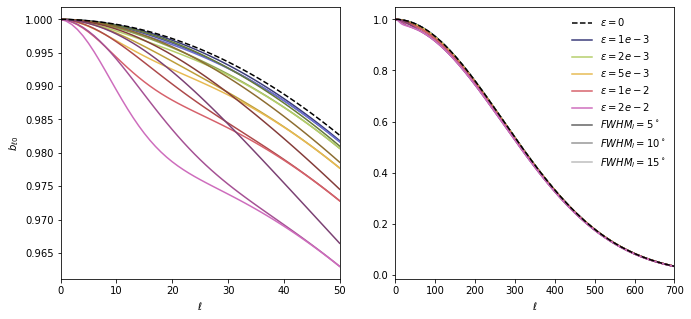

In [7]:
import matplotlib.cm
from matplotlib.lines import Line2D
colors = matplotlib.cm.get_cmap('tab20b')
shades = matplotlib.cm.get_cmap('tab20c')
fig, ax =plt.subplots(1,2, figsize=(11,5))
fwhm_main = 30.
for i, side_amp in enumerate([1e-3, 2e-3, 5e-3, 1e-2, 2e-2]):
    for j, side_fwhm in enumerate([5., 10., 15.]):
        blm_main = tools.gauss_blm(fwhm_main, lmax, pol=False)
        blm_main *= 1-side_amp
        blm_main = tools.get_copol_blm(blm_main, c2_fwhm=fwhm_main)
        blm_side = tools.gauss_blm(side_fwhm*60, lmax, pol=False)
        blm_side *= side_amp
        blm_side = tools.get_copol_blm(blm_side, c2_fwhm=side_fwhm*60)
        blm = (np.array(blm_side)+np.array(blm_main)).tolist()
        ax[0].plot(np.real(blm[0][:51]), c=colors(.2*i+.05*j))
        ax[1].plot(np.real(blm[0][:lmax+1]), c=colors(.2*i+.05*j))
ax[0].plot(np.real(blm_main[0][:51]/(1-side_amp)), 'k--')
ax[1].plot(np.real(blm_main[0][:lmax+1]/(1-side_amp)), 'k--')
custom_lines = [Line2D([0], [0], ls = '--', c = 'k'),
                Line2D([0], [0], c=colors(0.)),
                Line2D([0], [0], c=colors(0.3)),
                Line2D([0], [0], c=colors(0.5)),
                Line2D([0], [0], c=colors(0.7)),
                Line2D([0], [0], c=colors(0.9)),
                Line2D([0], [0], c=shades(0.8)),
                Line2D([0], [0], c=shades(0.85)),
                Line2D([0], [0], c=shades(0.9))
               ]
legend = [r'$\varepsilon = 0.$', r'$\varepsilon = 1e-3$', r'$\varepsilon = 2e-3$',
         r'$\varepsilon = 5e-3$', r'$\varepsilon = 1e-2$', r'$\varepsilon = 2e-2$',
          r'$FWHM_l=5^\circ$', r'$FWHM_l=10^\circ$', r'$FWHM_l=15^\circ$']
ax[0].set_xlim(0,50)
ax[1].set_xlim(0,700)
ax[1].legend(custom_lines, legend, frameon=False)
ax[0].set_xlabel(r"$\ell$")
ax[0].set_ylabel(r"$b_{\ell0}$")
ax[1].set_xlabel(r"$\ell$")
plt.savefig("beam_profiles")

Now for the proper beamconv part: we define beam options for a single detector, and a scan strategy using the ```ground``` keyword to save space for a horizontal coordinate pointing quaternion. By setting ```check_interval=nsamp``` we fix the elevation for the whole scan. 

In [8]:
#Beam options
import pickle

beam_opts = dict(az=0, el=0, polang=0.,                 
                 btype='PO', lmax=lmax, mmax=lmax,
                 po_file='./ancillary/gaussian_with_sidelobe.npy',
                 deconv_q=False)
center_beam = Beam(name='center_beam', **beam_opts)
#Scan strategy:
t0 = 1641000000#Some time on Jan 1st 2022
nsamp=60*60
rot_period=1e5
step_period = 1e5
# init scan strategy and instrument
scan_opts = dict(
            az_throw   = 360.,
            scan_speed = 1.,
            nside_spin = nside,
            el_min=0., 
            check_interval=nsamp,
            q_bore_kwargs={'ground':True},
            ctime_kwargs=dict(),
            max_spin=5,
            preview_pointing=False)

sata = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama', # Atacama instrument
                  rot_period=rot_period,
                  ctime0=t0) 
#Add a single detector, on the boresight. 
sata.add_to_focal_plane([center_beam])
#blank sky
blank = np.zeros(hp.nside2npix(nside))
blank_alm = hp.map2alm([blank, blank, blank], lmax=lmax)

#Pointing
qpo = qp.QPoint()
az0 = 0.
el0 = 50.
#Find the starting sky coordinates for beamconv
ra0ata, dec0ata, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])

The ground is scanned by adding the optional ```ground_alm``` to the ```scan_instrument_mpi``` call.

In [9]:
sata.scan_instrument_mpi(blank_alm, verbose=1, ra0=ra0ata, dec0=dec0ata, ground_alm=sine_alm,
                         binning=False, interp=True, save_tod=True, save_point=True, **scan_opts)
#Save data
sata_tod = sata._data["0"]["0"]["tod"].copy()
sata_pix = sata._data["0"]["0"]["pix"].copy()

#Redo but at south pole
spole = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='spole',# South pole instrument
                  rot_period=rot_period, 
                  ctime0=t0) 
spole.add_to_focal_plane([center_beam])
ra0spo, dec0spo, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [+180.], [-90.], [t0])
spole.scan_instrument_mpi(blank_alm, verbose=1, ra0=ra0spo, dec0=dec0spo, ground_alm=sine_alm, 
                          binning=False, interp = True, save_tod=True, save_point=True, **scan_opts)
spole_tod = spole._data["0"]["0"]["tod"].copy()
spole_pix = spole._data["0"]["0"]["pix"].copy()

#Get az, el for boresight
sata_az = np.empty(nsamp, dtype=np.float64)
sata_el = np.empty(nsamp, dtype=np.float64)
_ = sata.bore2radec(np.array([1,0,0,0]), sata.ctime, sata.q_boreground, ra=sata_az, dec=sata_el)
spole_az = np.empty(nsamp, dtype=np.float64)
spole_el = np.empty(nsamp, dtype=np.float64)
_ = spole.bore2radec(np.array([1,0,0,0]), spole.ctime, spole.q_boreground, ra=spole_az, dec=spole_el)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-3600
Scanning with 1 detectors


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-3600


Average el spole: 50.0982084907174
Average el atacama: 49.99199956112309


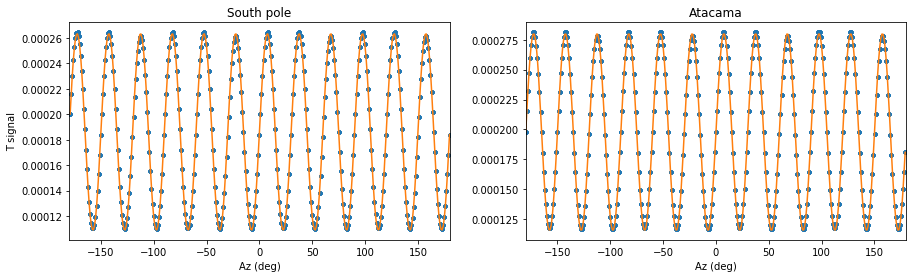

In [10]:
fig, ax= plt.subplots(1,2, figsize=(15,4))
sort_spole = np.argsort(spole_az)
sort_sata = np.argsort(sata_az)
ax[0].plot(spole_az[sort_spole], spole_tod[sort_spole], '.')
ax[1].plot(sata_az[sort_sata], sata_tod[sort_sata], '.')
ax[0].plot(spole_az[sort_spole], 
           np.average(spole_tod)+.5*np.ptp(spole_tod)*np.sin(12*np.radians(spole_az[sort_spole])))
ax[1].plot(sata_az[sort_sata], 
           np.average(sata_tod)+.5*np.ptp(sata_tod)*np.sin(12*np.radians(sata_az[sort_sata])))
ax[0].set_ylabel('T signal')
ax[0].set_xlabel('Az (deg)')
ax[1].set_xlabel('Az (deg)')
ax[0].set_title('South pole')
ax[1].set_title('Atacama')
ax[0].set_xlim(-180, 180)
ax[1].set_xlim(-180,180)
print('Average el spole: {}'.format(np.average(spole_el)))
print('Average el atacama: {}'.format(np.average(sata_el)))

Let's check it also works for detectors away from the boresight: 

Scanning with 3 detectors
[rank 000]:	Working on chunk 000: samples 0-3600


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-3600
[rank 000]:	Working on chunk 000: samples 0-3600


Text(0, 0.5, 'Signal')

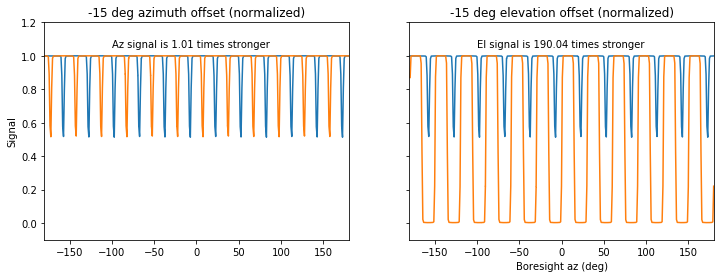

In [11]:
az_opts = dict(az=15, el=0, polang=0.,                 
                 btype='PO', lmax=lmax, mmax=lmax,
                 po_file='./ancillary/gaussian_with_sidelobe.npy',
                 deconv_q=False)
el_opts = dict(az=0, el=15, polang=0.,                 
                 btype='PO', lmax=lmax, mmax=lmax,
                 po_file='./ancillary/gaussian_with_sidelobe.npy',
                 deconv_q=False)
azoff = Beam(name='azoff', **az_opts)
eloff = Beam(name='eloff', **el_opts)

spole = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='spole',# South pole instrument
                  rot_period=rot_period, 
                  ctime0=t0) 
spole.add_to_focal_plane([azoff, eloff, center_beam])
ra0spo, dec0spo, _, _ = qpo.azel2radec(0,0,0, [az0], [0], [0.], [0.], [+180.], [-90.], [t0])#Align az with phi
spole.scan_instrument_mpi(blank_alm, verbose=1, ra0=ra0spo, dec0=dec0spo, ground_alm=sine_alm, 
                          binning=False, interp = True, save_tod=True, save_point=True, **scan_opts)
azoff_tod = spole._data["0"]["0"]["tod"].copy()
eloff_tod = spole._data["0"]["1"]["tod"].copy()
centr_tod = spole._data["0"]["2"]["tod"].copy()
bore_az = np.empty(nsamp, dtype=np.float64)
bore_el = np.empty(nsamp, dtype=np.float64)

_ = spole.bore2radec(np.array([1,0,0,0]), spole.ctime, spole.q_boreground, ra=bore_az, dec=bore_el)
sort_bore = np.argsort(bore_az)
fig, ax = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
ax[0].plot(bore_az[sort_bore], centr_tod[sort_bore]/np.amax(centr_tod))
ax[1].plot(bore_az[sort_bore], centr_tod[sort_bore]/np.amax(centr_tod))
ax[0].plot(bore_az[sort_bore], azoff_tod[sort_bore]/np.amax(azoff_tod))
ax[1].plot(bore_az[sort_bore], eloff_tod[sort_bore]/np.amax(eloff_tod))
ax[0].set_title("-15 deg azimuth offset (normalized)")
ax[1].set_title("-15 deg elevation offset (normalized)")
ax[0].text(-100, 1.05, "Az signal is {:.2f} times stronger".format(np.amin(azoff_tod)/np.amin(centr_tod)))
ax[1].text(-100, 1.05, "El signal is {:.2f} times stronger".format(np.amin(centr_tod)/np.amin(eloff_tod)))
ax[0].set_xlim(-180, 180)
ax[0].set_ylim(-0.1,1.2)
ax[1].set_xlabel("Boresight az (deg)")
ax[0].set_ylabel("Signal")

## The Atacama ground template
Let's do a scan of Atacama, with a different, more realistic ground.

In [12]:
gata = hp.smoothing(hp.read_map('./ancillary/ground_ata95.fits'), fwhm=np.pi/180.)
gata_alm = hp.map2alm([gata, np.zeros_like(gata), np.zeros_like(gata)], lmax = lmax)

beam_opts = dict(az=0, el=0, polang=0.,                 
                 btype='PO', lmax=lmax, mmax=lmax,
                 po_file='./ancillary/gaussian_with_sidelobe.npy',
                 deconv_q=False)

import time
t0 = time.time()
qpo = qp.QPoint()
az0 = 0.
el0 = 45.
az_throw   = 360.
scan_speed = 0.2
nsamp = 3600*24

ra0ata, dec0ata, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])

sata = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama',
                   ctime0=t0) # Atacama instrument
sata.add_to_focal_plane([center_beam])
sata.scan_instrument_mpi(blank_alm, ra0=ra0ata, dec0=dec0ata, az_throw=az_throw, 
                         scan_speed=scan_speed, el_min=0, check_interval=nsamp,
                         nside_spin=nside, max_spin=2, ground_alm=gata_alm,
                         interp=True, verbose=1,
                         binning=False, save_tod=True, save_point=True)
sata_tod = sata._data["0"]["0"]["tod"].copy()
sata_pix = sata._data["0"]["0"]["pix"].copy()
sata_az = np.empty(nsamp, dtype=np.float64)
sata_el = np.empty(nsamp, dtype=np.float64)
_ = sata.bore2radec(np.array([1,0,0,0]), sata.ctime, sata.q_boreground, ra=sata_az, dec=sata_el)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-86400


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


Text(0, 0.5, 'tod signal')

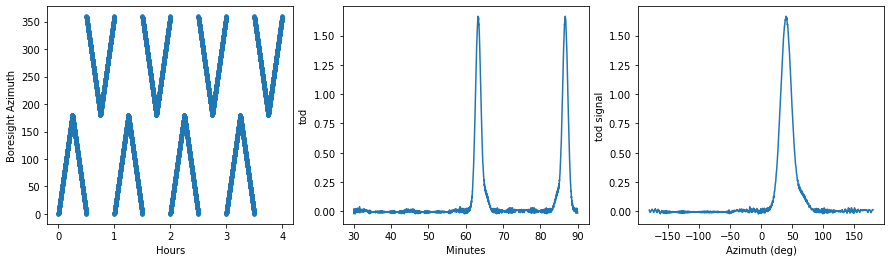

In [13]:
az_ata, el_ata = hp.pix2ang(nside, sata_pix, lonlat=True)
sort_az = np.argsort(sata_az)
fig, ax =plt.subplots(1,3, figsize=(15,4))
ax[0].plot(np.arange(3600*4)/3600., sata_az[:3600*4]%360, '.')
ax[0].set_xlabel("Hours")
ax[0].set_ylabel("Boresight Azimuth")
ax[1].plot(np.arange(1800, 5400)/60., sata_tod[1800:5400])
ax[1].set_xlabel("Minutes")
ax[1].set_ylabel("tod")
ax[2].plot(sata_az[sort_az], sata_tod[sort_az])
ax[2].set_xlabel("Azimuth (deg)")
ax[2].set_ylabel("tod signal")

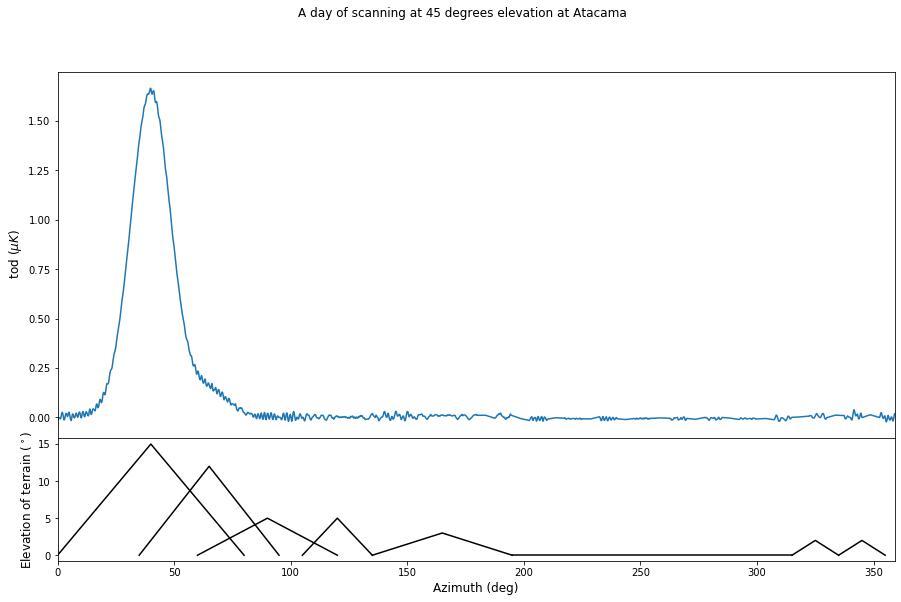

In [14]:
#Overlay the last panel with the mountains:
mount_az = np.array([40,65,90,120,165., 325, 345])
mount_el = np.array([15,12,5,5,3,2,2])
mount_hwidth = np.array([40.,30.,30.,15,30.,10.,10.])
west_sort = sort_az[sata_az<0.1]
fig, ax = plt.subplots(2,1, figsize=(15,9), sharex=True, gridspec_kw={"height_ratios":[3,1]})
ax[0].plot(sata_az[sort_az], sata_tod[sort_az], 'tab:blue')
ax[0].plot(sata_az[west_sort]+360, sata_tod[west_sort], 'tab:blue')
ax[1].set_xlabel("Azimuth (deg)", size=12)
ax[0].set_ylabel(r" tod $(\mu K)$", size=12)
for i in range(7):
    ax[1].plot([mount_az[i]-mount_hwidth[i], mount_az[i], mount_az[i]+mount_hwidth[i]], [0, mount_el[i], 0], 'k')
ax[1].plot([195,315],[0,0], 'k')
ax[1].set_xlim(0,359)
ax[1].set_ylabel(r"Elevation of terrain $(^\circ)$", size=12)
plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("A day of scanning at 45 degrees elevation at Atacama")
plt.savefig("SimpleGroundScanSidelobe45.png", dpi=200)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-86400


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


Text(0.5, 0.98, 'A day of scanning at 55° elevation at Atacama')

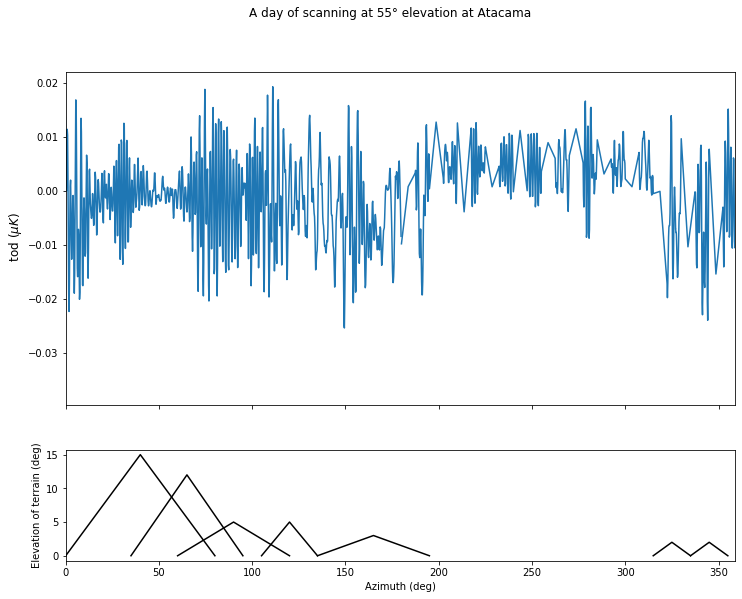

In [15]:
#Same scan at 55° elevation

el0 = 55.

ra0ata, dec0ata, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])

sata = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama',
                   ctime0=t0) # Atacama instrument
sata.add_to_focal_plane([center_beam])
sata.scan_instrument_mpi(blank_alm, ra0=ra0ata, dec0=dec0ata, az_throw=az_throw, 
                         scan_speed=scan_speed, el_min=0, check_interval=nsamp,
                         nside_spin=nside, max_spin=2, ground_alm=gata_alm,
                         interp=True, verbose=1,
                         binning=False, save_tod=True, save_point=True)
sata_tod = sata._data["0"]["0"]["tod"].copy()
sata_pix = sata._data["0"]["0"]["pix"].copy()
sata_az = np.empty(nsamp, dtype=np.float64)
sata_el = np.empty(nsamp, dtype=np.float64)
_ = sata.bore2radec(np.array([1,0,0,0]), sata.ctime, sata.q_boreground, ra=sata_az, dec=sata_el)
sort_az = np.argsort(sata_az)
west_sort = sort_az[sata_az<0.1]
fig, ax = plt.subplots(2,1, figsize=(12,9), sharex=True, gridspec_kw={"height_ratios":[3,1]})
ax[0].plot(sata_az[sort_az], sata_tod[sort_az], 'tab:blue')
ax[0].plot(sata_az[west_sort]+360, sata_tod[west_sort], 'tab:blue')
ax[1].set_xlabel("Azimuth (deg)")
ax[0].set_ylabel(r" tod $(\mu K)$", size=12)
for i in range(7):
    ax[1].plot([mount_az[i]-mount_hwidth[i], mount_az[i], mount_az[i]+mount_hwidth[i]], [0, mount_el[i], 0], 'k')
ax[1].set_xlim(0,359)
ax[1].set_ylabel("Elevation of terrain (deg)")
fig.suptitle("A day of scanning at 55° elevation at Atacama")
#plt.savefig("SimpleGroundScanSidelobe55")

## Co-adding sky scans
We try to recover the ground template from a ground+sky scan.

In [16]:
#sky
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt', unpack=True)
ell, cls = cls[0], cls[1:]
np.random.seed(25) 
sky_alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) 

t0 = 1640991600
qpo = qp.QPoint()
ra0, dec0, _, _ = qpo.azel2radec(0,0,0, [0], [50], [0.], [0.], [-67.786], [-22.958], [t0])
mlen = 60*6
#Scan
scan_opts = dict(
            ra0=[ra0], 
            dec0=[dec0],
            az_throw   = 360.,
            scan_speed = 1.,
            nside_spin = nside,
            el_min=0., 
            check_interval=mlen,
            q_bore_kwargs={'ground':False},
            ctime_kwargs=dict(),
            max_spin=5,
            preview_pointing=False)

scan_sky = ScanStrategy(duration=mlen, sample_rate=50.01, location='atacama', ctime0 = t0)
scan_sky.add_to_focal_plane([center_beam])
scan_sky.scan_instrument_mpi(sky_alm, binning=False, interp=True, save_tod=True, **scan_opts)

#Sine
scan_opts['q_bore_kwargs']={'ground':True}
scan_sine = ScanStrategy(duration=mlen, sample_rate=50.01, location='atacama', ctime0 = t0)
scan_sine.add_to_focal_plane([center_beam])
scan_sine.scan_instrument_mpi(sky_alm, binning=False, interp=True, save_tod=True, ground_alm=sine_alm, **scan_opts)

#Atacama
scan_atac = ScanStrategy(duration=mlen, sample_rate=50.01, location='atacama', ctime0 = t0)
scan_atac.add_to_focal_plane([center_beam])
scan_atac.scan_instrument_mpi(sky_alm, binning=False, interp=True, save_tod=True, ground_alm=gata_alm, **scan_opts)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-18003
Scanning with 1 detectors


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-18003
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-18003


We substract the TOD of the sky-only scan from the two others.

Text(0.5, 1.0, 'Sky only')

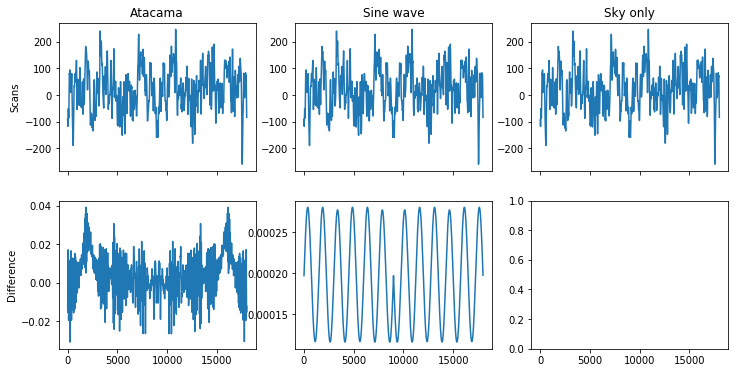

In [17]:
scan_atac_tod = scan_atac._data['0']['0']['tod'].copy()
scan_sine_tod = scan_sine._data['0']['0']['tod'].copy()
scan_sky_tod = scan_sky._data['0']['0']['tod'].copy()
fig, ax = plt.subplots(2,3, sharex=True, figsize=(12,6))
ax[0,0].plot(scan_atac_tod)
ax[0,1].plot(scan_sine_tod)
ax[0,2].plot(scan_sky_tod)
ax[1,0].plot(scan_atac_tod - scan_sky_tod)
ax[1,1].plot(scan_sine_tod - scan_sky_tod)
ax[0,0].set_ylabel("Scans")
ax[1,0].set_ylabel("Difference")
ax[0,0].set_title("Atacama")
ax[0,1].set_title("Sine wave")
ax[0,2].set_title("Sky only")
#plt.savefig("ssn50elev")

Text(0, 0.5, '$\\Delta$ with sky, $\\mu K$')

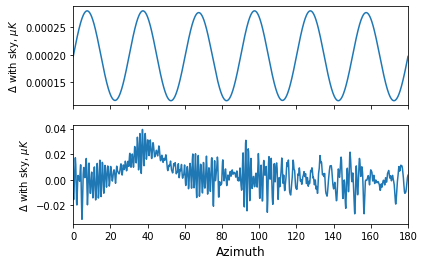

In [18]:
az_atac = np.empty(int(mlen*50.01), dtype=np.float64)
el_atac = np.empty(int(mlen*50.01), dtype=np.float64)
_ = scan_atac.bore2radec(np.array([1,0,0,0]), scan_atac.ctime, scan_atac.q_boreground, ra=az_atac, dec=el_atac)
sortidx_az = np.argsort(az_atac)
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(az_atac[sortidx_az], (scan_sine_tod-scan_sky_tod)[sortidx_az])
ax[1].plot(az_atac[sortidx_az], (scan_atac_tod-scan_sky_tod)[sortidx_az])
ax[1].set_xlabel("Azimuth", size=12)
ax[1].set_xlim(0,180)
ax[0].set_ylabel(r'$\Delta$ with sky, $\mu K$')
ax[1].set_ylabel(r'$\Delta$ with sky, $\mu K$')

As we can see, the signal isn't enormous and the excess for the Atacama template is concentrated on the main mountain, Cerro Toco. Let's look at different elevation passes over that mountain.

In [19]:
elevs = np.linspace(45, 50, num=6)
mlen = 600
sample_rate = 1
nsamp = int(mlen*sample_rate)
tod_stream = np.zeros((11,nsamp))
az_stream = np.zeros((11,nsamp))


az0 = 0.

az_throw   = 360.
scan_speed = 0.2
blank = np.zeros(hp.nside2npix(nside))
blank_alm = hp.map2alm([blank, blank, blank], lmax=lmax)
for i, el0 in enumerate(elevs):
    ra0ata, dec0ata, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])
    sata = ScanStrategy(mlen, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama',
                   ctime0=t0) # Atacama instrument
    sata.add_to_focal_plane([center_beam])
    sata.scan_instrument_mpi(blank_alm, ra0=ra0ata, dec0=dec0ata, az_throw=az_throw, 
                         scan_speed=scan_speed, el_min=0, check_interval=mlen,
                         nside_spin=nside, max_spin=2, ground_alm=gata_alm,
                         interp=True, verbose=1,
                         binning=False, save_tod=True, save_point=True)
    tod_stream[i] = sata._data["0"]["0"]["tod"].copy()
    az_stream[i] = np.empty(nsamp, dtype=np.float64)
    sata_el = np.empty(nsamp, dtype=np.float64)
    _ = sata.bore2radec(np.array([1,0,0,0]), sata.ctime, sata.q_boreground, ra=az_stream[i], dec=sata_el)
    
    

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-600
Scanning with 1 detectors


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-600
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-600
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-600
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-600
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-600


Text(0.5, 1.0, '$1\\%$ sidelobe, FWHM $15^\\circ$')

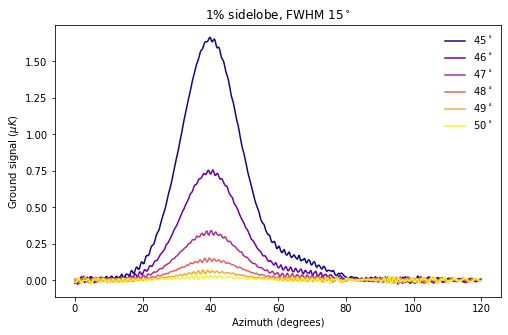

In [20]:
import matplotlib.cm 
from matplotlib.lines import Line2D
colors = matplotlib.cm.get_cmap('plasma')
fig = plt.figure(figsize=(8,5))
for i, el0 in enumerate(elevs):
    plt.plot(az_stream[i], tod_stream[i], color=colors(i/5), label=str(int(el0))+r"$^\circ$")
plt.xlabel("Azimuth (degrees)")
plt.ylabel(r"Ground signal $(\mu K)$")
plt.legend(frameon=False)
plt.title(r"$1\%$ sidelobe, FWHM $15^\circ$")
#plt.savefig("main_peak_passes")